# Customer Churn Prediction #

## Load Packages ##

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer
# need this for label-encode multiple columns
# from collections import defaultdict 

from lifelines import CoxPHFitter
from lightgbm import LGBMClassifier
import lightgbm as lgb
        
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

import warnings

np.random.seed(0)

## Load, Inspect, and Clean Data ##

In [2]:
working_dir = "/home/lee/Documents/Datasets for GitHub/kaggle_telco_customer_churn/"
df = pd.read_csv(working_dir+'WA_Fn-UseC_-Telco-Customer-Churn.csv', header=0, index_col=0)

In [3]:
print("data size: {}".format(df.shape))
print("\n")
print("preview:\n{}".format(df.head()))
print("\n")
print("summary:\n{}".format(df.describe()))
print("\n")
print("column data types:\n{}".format(df.dtypes))
print("\n")

data size: (7043, 20)


preview:
            gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                  
7590-VHVEG  Female              0     Yes         No       1           No   
5575-GNVDE    Male              0      No         No      34          Yes   
3668-QPYBK    Male              0      No         No       2          Yes   
7795-CFOCW    Male              0      No         No      45           No   
9237-HQITU  Female              0      No         No       2          Yes   

               MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                                 
7590-VHVEG  No phone service             DSL             No          Yes   
5575-GNVDE                No             DSL            Yes           No   
3668-QPYBK                No             DSL            Yes          Yes   
7795-CFOCW  No phone service             DSL   

`TotalCharges` is not recognized as a numeric column. Why? 

In [4]:
TotalCharges = df['TotalCharges'].copy()
TotalCharges = TotalCharges.str.replace('.', '')
print(df[TotalCharges.str.isnumeric() == False])
del TotalCharges

            gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                  
4472-LVYGI  Female              0     Yes        Yes       0           No   
3115-CZMZD    Male              0      No        Yes       0          Yes   
5709-LVOEQ  Female              0     Yes        Yes       0          Yes   
4367-NUYAO    Male              0     Yes        Yes       0          Yes   
1371-DWPAZ  Female              0     Yes        Yes       0           No   
7644-OMVMY    Male              0     Yes        Yes       0          Yes   
3213-VVOLG    Male              0     Yes        Yes       0          Yes   
2520-SGTTA  Female              0     Yes        Yes       0          Yes   
2923-ARZLG    Male              0     Yes        Yes       0          Yes   
4075-WKNIU  Female              0     Yes        Yes       0          Yes   
2775-SEFEE    Male              0      No        Yes       0          Yes   

All these customers have a tenure of 0. Looks like they are all brand new customers and have not paid any bills yet. Set their `TotalCharges` to 0. 

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

Now we look at missingness. 

In [6]:
print("columns with at least 1 NaN value: \n{}".format(df.columns[df.isna().any()].tolist()))

columns with at least 1 NaN value: 
[]


No missing data. 

Are the classes of our target balanced?

In [7]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

Looks well balanced. 

## EDA ##

Looking at the customer attributes, only `tenure`, `MonthlyCharges`, and `TotalCharges` are continuous. The rest are all categorical. 

In [9]:
# group features to groups, continuous and categorical
columns_all = tuple(df.columns)

continuous_features_set = set(('tenure', 'MonthlyCharges', 'TotalCharges'))
continuous_features = tuple(col for col in columns_all if (col in continuous_features_set) == True)

categorical_features_set = set(columns_all) - continuous_features_set - set(['Churn'])
categorical_features = tuple(col for col in columns_all if (col in categorical_features_set) == True)

binary_features_set = set(('gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'))
binary_features = tuple(col for col in columns_all if (col in binary_features_set) == True)

non_binary_features_set = categorical_features_set - binary_features_set
non_binary_features = tuple(col for col in columns_all if (col in non_binary_features_set) == True)

del continuous_features_set, categorical_features_set, binary_features_set, non_binary_features_set

### Visualization ###

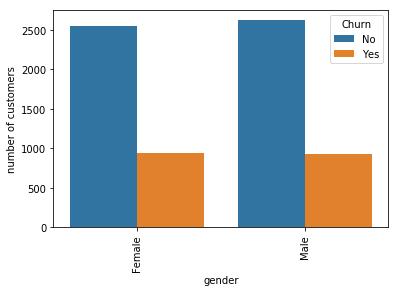

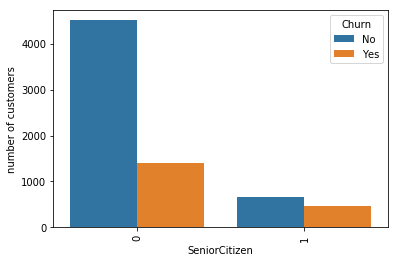

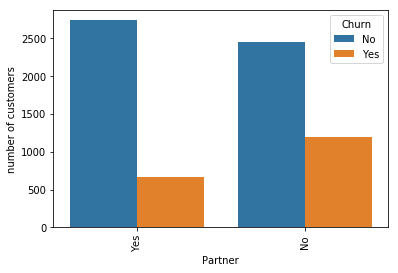

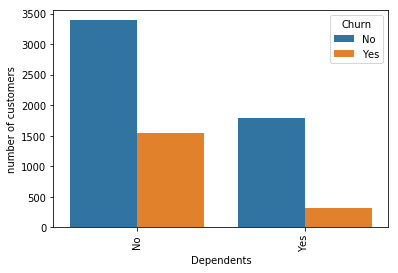

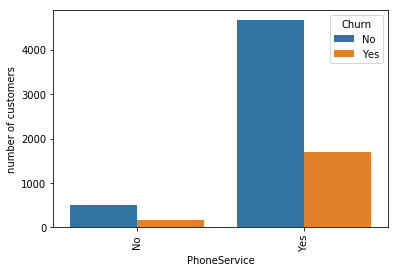

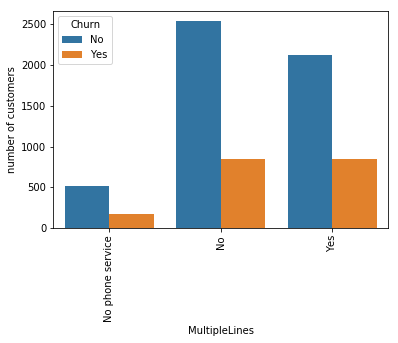

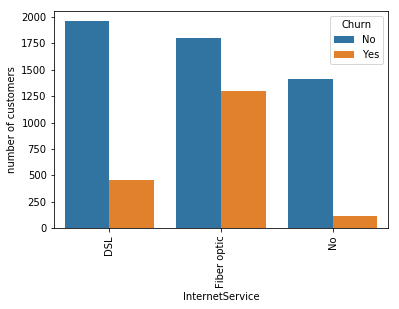

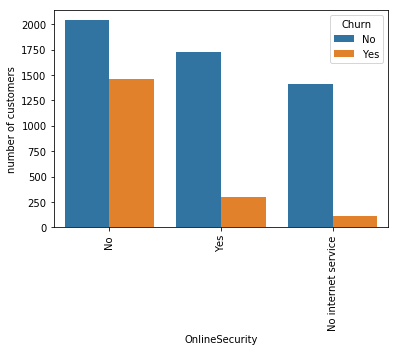

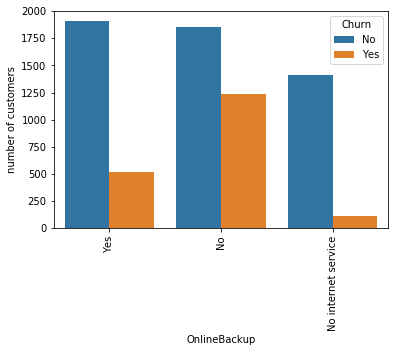

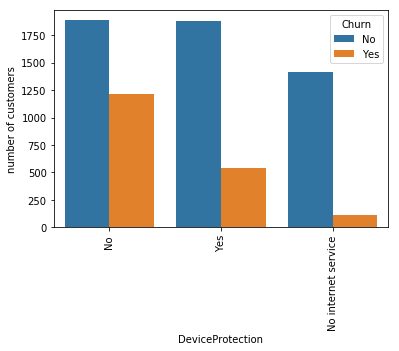

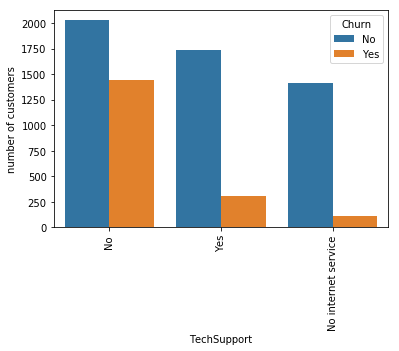

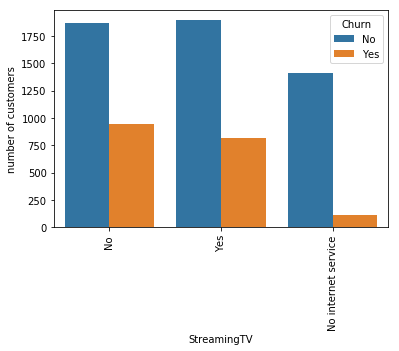

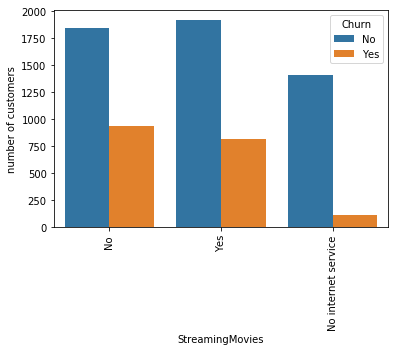

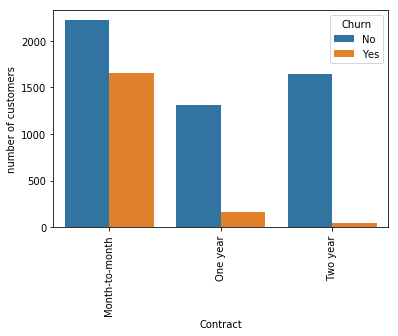

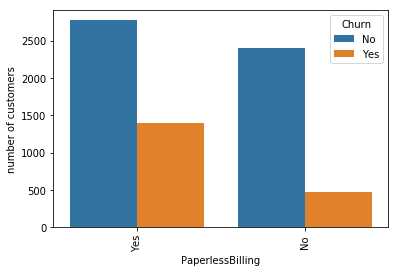

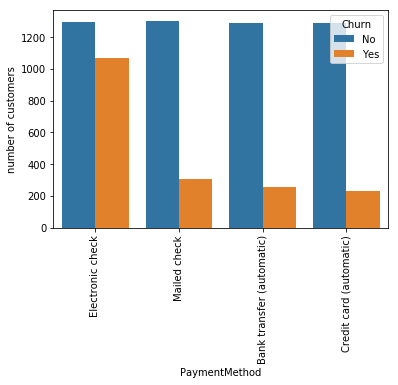

In [10]:
for feature in categorical_features:
    sns.countplot(x=feature, hue="Churn", data=df)
    plt.xticks(rotation=90)
    plt.ylabel('number of customers')
    plt.show()

Observations and thoughts:
* Senior citizens appear to churn more. Does this mean our service is not friendly to senior citizens?
* Fiber optic users churn more. Is our fiber optic service unsatisfying?
* Among customers with internet service, having online security makes them less likely to churn. 
* Customers that pay with electronic check churn more - even more than the customers that go through the inconvenience of mailing in a check. Is our payment system functioning as expected here? 
* It is expected that customers that are on longer-term contracts are less likely to churn. But are we providing satisfying services to our month-to-month customers?
* I find it reasonable to assume 1) most the dependents are children that live with their parents and 2) their user satification factors into the parents' decision whether to continue using our services. Looks like we are serving our young users well. 

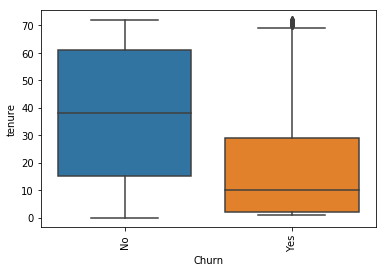

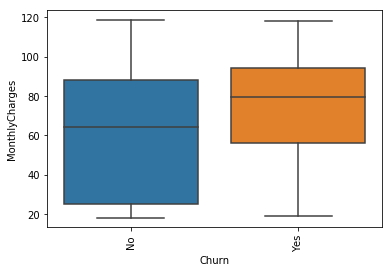

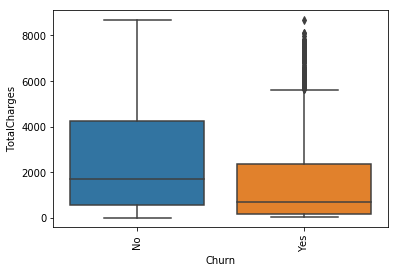

In [11]:
for feature in continuous_features:
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.xticks(rotation=90)
    plt.show()

Both `tenure` and `TotalCharges` are right censored: for a currently active member, we will not observe their lifetime total charges until when they actually cancel the service. The distributions of these features in the "Churn=No" group themselves do not give us much information other than a lower bound. However, there is insight when we look at all three boxplots together. Churned customers have higher monthly charges. Their tenure is substantially shorter than that of the active customers, but their total charges are quite high - approximately the same range with that of the active members. Churned customer also have a number of extremely high total charges. 

## Feature Engineering ##

We will use tree-based methods, so we will not scale the continuous features. 

For the categorical features, in unseen test data we expect their attributes to still fall into the categories that we have seen in the training data. We decide to one-hot encode the entire dataset before we split it into training and testing samples.

In [12]:
# transform target
lb = LabelBinarizer()
df['Churn'] = lb.fit_transform(df['Churn'])

# separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

code_f = {'Female': 0, 'Male': 1, 'No': 0, 'Yes': 1}
for col in binary_features:
    X[col] = X[col].replace(to_replace = code_f)
    
cat_transformed = pd.get_dummies(X.filter(items=categorical_features))

Now we remove the linearly dependent columns. For example, if `PhoneService`=0 and `MultipleLines_Yes`=1, we know `MultipleLines_No`=0 and `MultipleLines_No phone service`=0. The latter two columns are linearly dependent on the former two columns. Keeping the latter two in the data not only adds no information but also makes the matrix singular, leading to computation error in the survival analysis that we will conduct. 

In [13]:
full_rank_cat_transformed = cat_transformed.drop(['MultipleLines_No', 'MultipleLines_No phone service', 
                                                  'InternetService_No', 'OnlineSecurity_No',
                                                  'OnlineSecurity_No internet service','OnlineBackup_No',
                                                  'OnlineBackup_No internet service', 'DeviceProtection_No',
                                                  'DeviceProtection_No internet service', 'TechSupport_No',
                                                  'TechSupport_No internet service', 'StreamingTV_No', 
                                                  'StreamingTV_No internet service', 'StreamingMovies_No', 
                                                  'StreamingMovies_No internet service', 'Contract_Month-to-month',
                                                  'PaymentMethod_Bank transfer (automatic)'], axis=1).copy()
df_full_rank = pd.concat((y, X.filter(items=continuous_features), full_rank_cat_transformed), axis=1)

## Modeling ##

### Survival Analysis with Cox Proportional Hazards Regression ###

We are facing a typical survival analysis problem, where a customer is active for the duration of their `tenure` until the event `Churn` happens. Analyzing the data from this angle identifies strong risk factors of the event `Churn`, enabling us to develop customer-group-level retention interventions. For example, if we identify that not having online security is a strong risk factor of customer churn, we can promote online security as a way of increasing customer retention. If we identify having DSL as a risk factor relative to having fiber optic, while we ought not to simply promote fiber optic, we may conclude that our DSL service leaves much to be improved and initiate a quality improvement project. 

For this analysis we will use the entire dataset without breaking it into training/testing samples, as we are not looking to make customer-level predictions.

In [14]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df_full_rank, 'tenure', event_col='Churn')
cph.print_summary()

n=7043, number of events=1869

                                         coef  exp(coef)  se(coef)        z      p  lower 0.95  upper 0.95     
MonthlyCharges                         0.0132     1.0132    0.0230   0.5727 0.5668     -0.0319      0.0582     
TotalCharges                          -0.0016     0.9984    0.0000 -39.1628 0.0000     -0.0017     -0.0015  ***
gender                                -0.0394     0.9614    0.0466  -0.8459 0.3976     -0.1307      0.0519     
SeniorCitizen                          0.0345     1.0351    0.0566   0.6090 0.5425     -0.0764      0.1453     
Partner                               -0.1780     0.8369    0.0551  -3.2329 0.0012     -0.2859     -0.0701   **
Dependents                            -0.0915     0.9125    0.0698  -1.3109 0.1899     -0.2284      0.0453     
PhoneService                           0.8282     2.2891    0.4742   1.7465 0.0807     -0.1012      1.7576    .
PaperlessBilling                       0.1498     1.1616    0.0566   2.64

Look at feature importance visually. 

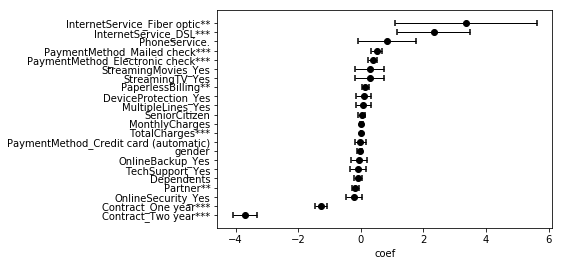

In [15]:
cph.plot()

Having fiber optic Internet service is the strongest risk factor of churn! This agrees with what we saw in the bargraphs earlier. 

### Individual Churn Prediction with LightGBM Classification ###

Here we try to predict, with the observations at hand (e.g., a customer has been active for 10 months so far, with a monthly charge of $40 and DSL Internet, etc.), how likely is an individual customer to churn in this month. This becomes a classification approach and we will use LightGBM classifier for the analysis. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_full_rank.drop('Churn', axis=1), y, test_size=0.2, random_state=0)

In [18]:
estimator = LGBMClassifier(random_state=0)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 30, 40],
    'num_leaves': [20, 30, 40],
    'min_child_weight': [0.001, 0.01, 0.1, 1]
}

warnings.filterwarnings("ignore", category=DeprecationWarning) 
lgb_cv = GridSearchCV(estimator, param_grid)

lgb_cv.fit(X_train, y_train)

print('Best hyperparameters found by grid search are:', lgb_cv.best_params_)
warnings.filterwarnings("default", category=DeprecationWarning) 

Best hyperparameters found by grid search are: {'learning_rate': 0.1, 'min_child_weight': 0.001, 'n_estimators': 30, 'num_leaves': 20}


In [20]:
clf_lgb = LGBMClassifier(**lgb_cv.best_params_)
clf_lgb.fit(X_train, y_train)
print("AUC in training set: {:0.4f}".format(roc_auc_score(y_train, clf_lgb.predict_proba(X_train)[:, 1])))
print("AUC in testing set: {:0.4f}".format(roc_auc_score(y_test, clf_lgb.predict_proba(X_test)[:, 1])))

AUC in training set: 0.8832
AUC in testing set: 0.8298


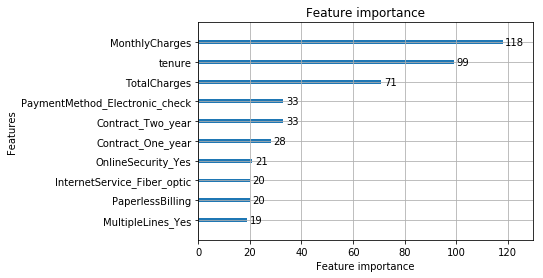

In [21]:
lgb.plot_importance(clf_lgb, max_num_features=10)

Monthly charge is the strongest predictor of customer churn. This agrees with what we saw in the boxplots. Does this mean we need to restructure our services and promote lower-priced service plans? On the other hand, it is possible that we get more profit from the high-paying customers even with their relatively high churn rate. Without profit information we will not be able to answer this question today, but this is definitely worth looking into. 

## Conclusions ##

* We have identified some customer-group-level attributes that appear to lead to customer churn, such as having fiber optic internet service. We need to make business actions evaluating these services we offer and potentially initiate internal quality improvement programs. 
* At an individual level we have identified that customers that have high charges are likely to leave. One way to prevent churn is to constantly monitor customers' monthly bills and total charges, and potentially offer discounts to them if we predict they are about to churn.  